In [1]:
import sys    
print('Running on Python version: {}'.format(sys.version))


Running on Python version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


The point of this NB is to show that relative to certain models, certain models, some NU error criteria are in conflict with each other.
The way I show this is to optimize a model with all parameters free to vary, while resulting models are compared against only NU error measurement at a time. In this way I show that the parameter sets of non conflicted (compatible) waveform measurements correspond to model parameter sets that are clustered togethor.

Note: on reproducing this environment. This env is supposed to be dependency light, since we are potentially only analysing data, as opposed to generating it. 

# Pickle Data File is publically available at:
https://osf.io/7xn2m/

The pickle file contains backend content.
neuronunit.model.backend.__init__ is called which attempts to load complex dependencies: pyNN, NEURON etc.
How to stop this from happening.


Assumptions, the environment for running this notebook was arrived at by building a dedicated docker file.

https://cloud.docker.com/repository/registry-1.docker.io/russelljarvis/nuo

You can run use dockerhub to get the appropriate file, and launch this notebook using Kitematic.

# Import libraries
To keep the standard running version of minimal and memory efficient, not all available packages are loaded by default. In the cell below I import a mixture common python modules, and custom developed modules associated with NeuronUnit (NU) development

In [2]:
import sys    
print('Running on Python version: {}'.format(sys.version))

import numpy as np
import os
import pickle
import pandas as pd
from neuronunit.tests.fi import RheobaseTestP
from neuronunit.optimization.model_parameters import reduced_dict, reduced_cells  
from neuronunit.optimization import optimization_management as om
from sciunit import scores# score_type 

from neuronunit.optimization.data_transport_container import DataTC
from neuronunit.tests.fi import RheobaseTestP# as discovery
from neuronunit.optimization.optimization_management import dtc_to_rheo, format_test, nunit_evaluation
import quantities as pq
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
list_to_frame = []
from neuronunit.tests.fi import RheobaseTestP

    
from IPython.display import HTML, display
import seaborn as sns


Running on Python version: 3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


/opt/conda/lib/python3.5/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


# The Izhiketich model is instanced using some well researched parameter sets.


First lets get the points in parameter space, that Izhikich himself has published about. These points are often used by the open source brain project to establish between model reproducibility. The itial motivating factor for choosing these points as constellations, of all possible parameter space subsets, is that these points where initially tuned and used as best guesses for matching real observed experimental recordings.

In [3]:
explore_param = {k:(np.min(v),np.max(v)) for k,v in reduced_dict.items()}

## Get the experimental Data pertaining to four different classes or neurons, that can constrain models.
Next we get some electro physiology data for four different classes of cells that are very common targets of scientific neuronal modelling. We are interested in finding out what are the most minimal, and detail reduced, low complexity model equations, that are able to satisfy 

Below are some of the data set ID's I used to query neuroelectro.
To save time for the reader, I prepared some data earlier to save time, and saved the data as a pickle, pythons preferred serialisation format.

The interested reader can find some methods for getting cell specific ephys data from neuroelectro in a code file (neuronunit/optimization/get_neab.py) 


In [4]:
purkinje ={"id": 18, "name": "Cerebellum Purkinje cell", "neuron_db_id": 271, "nlex_id": "sao471801888"}
fi_basket = {"id": 65, "name": "Dentate gyrus basket cell", "neuron_db_id": None, "nlex_id": "nlx_cell_100201"}
pvis_cortex = {"id": 111, "name": "Neocortex pyramidal cell layer 5-6", "neuron_db_id": 265, "nlex_id": "nifext_50"}
#This olfactory mitral cell does not have datum about rheobase, current injection values.
olf_mitral = {"id": 129, "name": "Olfactory bulb (main) mitral cell", "neuron_db_id": 267, "nlex_id": "nlx_anat_100201"}
ca1_pyr = {"id": 85, "name": "Hippocampus CA1 pyramidal cell", "neuron_db_id": 258, "nlex_id": "sao830368389"}
pipe = [ fi_basket, ca1_pyr, purkinje,  pvis_cortex]

In [5]:
electro_tests = []
obs_frame = {}
test_frame = {}

from neuronunit.optimization import get_neab
try: 

    electro_path = str(os.getcwd())+'all_tests.p'

    assert os.path.isfile(electro_path) == True
    with open(electro_path,'rb') as f:
        (obs_frame,test_frame) = pickle.load(f)

except:
    for p in pipe:
        p_tests, p_observations = get_neab.get_neuron_criteria(p)
        obs_frame[p["name"]] = p_observations#, p_tests))
        test_frame[p["name"]] = p_tests#, p_tests))
    electro_path = str(os.getcwd())+'all_tests.p'
    with open(electro_path,'wb') as f:
        pickle.dump((obs_frame,test_frame),f)

# Cast the tabulatable data to pandas data frame
There are many among us who prefer potentially tabulatable data to be encoded in pandas data frame.

In [6]:
'''
for k,v in test_frame.items():
    if "olf_mit" not in k:
        obs = obs_frame[k]
        v[0] = RheobaseTestP(obs['Rheobase'])
df = pd.DataFrame.from_dict(obs_frame)
print(test_frame.keys())
'''

dict_keys(['Cerebellum Purkinje cell', 'Dentate gyrus basket cell', 'Hippocampus CA1 pyramidal cell', 'Neocortex pyramidal cell layer 5-6'])


In the data frame below, you can see many different cell types

In [7]:
df


,Cerebellum Purkinje cell,Dentate gyrus basket cell,Hippocampus CA1 pyramidal cell,Neocortex pyramidal cell layer 5-6
Cell Capacitance,"{'mean': 620.2725 pF, 'std': 261.303030538779 ...",NaN,"{'mean': 89.7960714285714 pF, 'std': 53.649763...","{'mean': 150.584166666667 pF, 'std': 139.68388..."
Input Resistance,"{'mean': 142.057692307692 Mohm, 'std': 68.9775...","{'mean': 222.475 Mohm, 'std': 168.291196665185...","{'mean': 107.080327644332 Mohm, 'std': 77.5774...","{'mean': 120.672073643411 Mohm, 'std': 77.6331..."
Membrane Time Constant,NaN,"{'mean': 13.25 ms, 'std': 3.25 ms, 'n': 2}","{'mean': 24.5021946169772 ms, 'std': 21.487785...","{'mean': 15.7342424242424 ms, 'std': 7.3116263..."
Resting membrane potential,"{'mean': -61.5916666666667 mV, 'std': 5.633265...","{'mean': -62.3 mV, 'std': 4.04722126896961 mV,...","{'mean': -65.2261863636364 mV, 'std': 4.888644...","{'mean': -68.2481434599156 mV, 'std': 6.532347..."
Rheobase,"{'mean': 680.794444444444 pA, 'std': 454.39011...","{'mean': 106.7 pA, 'std': 0.0 pA, 'n': 1}","{'mean': 189.24 pA, 'std': 287.163664156461 pA...","{'mean': 213.849583333333 pA, 'std': 170.45245..."
Spike Amplitude,"{'mean': 71.2308333333333 mV, 'std': 9.8322218...","{'mean': 78.6 mV, 'std': 5.7 mV, 'n': 2}","{'mean': 86.364525297619 mV, 'std': 12.2626088...","{'mean': 80.4351020408164 mV, 'std': 12.748803..."
Spike Half-Width,"{'mean': 0.41412962962963 ms, 'std': 0.1899317...","{'mean': 0.9975 ms, 'std': 0.442175021908746 m...","{'mean': 1.31895278450363 ms, 'std': 0.6083075...","{'mean': 1.20769387755102 ms, 'std': 0.5343459..."
Spike Threshold,"{'mean': -46.8947619047619 mV, 'std': 6.950900...","{'mean': -38.4 mV, 'std': 3.4 mV, 'n': 2}","{'mean': -47.5985714285714 mV, 'std': 7.726705...","{'mean': -42.7357232704403 mV, 'std': 8.040732..."


In [8]:
df['Hippocampus CA1 pyramidal cell']

# enable R style caching.
#!pip install git+https://github.com/rossant/ipycache
#%load_ext ipycache

Cell Capacitance              {'mean': 89.7960714285714 pF, 'std': 53.649763...
Input Resistance              {'mean': 107.080327644332 Mohm, 'std': 77.5774...
Membrane Time Constant        {'mean': 24.5021946169772 ms, 'std': 21.487785...
Resting membrane potential    {'mean': -65.2261863636364 mV, 'std': 4.888644...
Rheobase                      {'mean': 189.24 pA, 'std': 287.163664156461 pA...
Spike Amplitude               {'mean': 86.364525297619 mV, 'std': 12.2626088...
Spike Half-Width              {'mean': 1.31895278450363 ms, 'std': 0.6083075...
Spike Threshold               {'mean': -47.5985714285714 mV, 'std': 7.726705...
Name: Hippocampus CA1 pyramidal cell, dtype: object

# Tweak Izhikitich equations
with educated guesses based on information that is already encoded in the predefined experimental observations.

In otherwords use information that is readily amenable into hardcoding into equations 

Select out the 'Neocortex pyramidal cell layer 5-6' below, as a target for optimization

In [9]:
free_params = ['a','b','k','c','C','d','vPeak','vr']
hc_ = reduced_cells['RS']
hc_['vr'] = -65.2261863636364
hc_['vPeak'] = hc_['vr'] + 86.364525297619
explore_param['C'] = (hc_['C']-20,hc_['C']+20)
explore_param['vr'] = (hc_['vr']-5,hc_['vr']+5)
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]

test_opt = {}

with open('data_dump.p','wb') as f:
    pickle.dump(test_opt,f)

In [10]:

use_test[0].observation
print(use_test[0].name)

rtp = RheobaseTestP(use_test[0].observation)
use_test[0] = rtp
print(use_test[0].observation)

RheobaseTestP
{'mean': array(213.849583333333) * pA, 'std': array(170.452454715608) * pA, 'n': 32}


In [51]:
MU = 6
NGEN = 200

import pickle
import numpy as np
print(free_params)
    
MU = 6
NGEN = 25

import pickle
test_opt = {}
import numpy as np
try:
    with open('multi_dimension_per_single_criteria.p','rb') as f:
        test_opt = pickle.load(f)
except:

    for index,test in enumerate(use_test):

        ga_out, DO = om.run_ga(explore_param,NGEN,[test],free_params=free_params, NSGA = True, MU = MU)

        test_opt[test] = ga_out
        with open('multi_dimension_per_single_criteria.p','wb') as f:
            pickle.dump(test_opt,f)



['a', 'b', 'k', 'c', 'C', 'd', 'vPeak', 'vr']


In [52]:
test_opt.keys()

dict_keys([<neuronunit.tests.passive.CapacitanceTest object at 0x7fd37f8a2b00>, <neuronunit.tests.passive.RestingPotentialTest object at 0x7fd3a08455f8>, <neuronunit.tests.fi.RheobaseTestP object at 0x7fd37fbd9630>, <neuronunit.tests.passive.TimeConstantTest object at 0x7fd38840eef0>, <neuronunit.tests.waveform.InjectedCurrentAPThresholdTest object at 0x7fd38817c668>, <neuronunit.tests.waveform.InjectedCurrentAPAmplitudeTest object at 0x7fd3a08af860>, <neuronunit.tests.waveform.InjectedCurrentAPWidthTest object at 0x7fd3a08b5eb8>, <neuronunit.tests.passive.InputResistanceTest object at 0x7fd3a34020f0>])

In [53]:
#test_opt

In [54]:

X = []
ranges = {}
best = {}
all_val = {}
for key,value in test_opt.items():
    ranges[key] = {}
    best[key] = {}
    all_val[key] = {}
    for k in value['hof'][0].dtc.attrs.keys():
        
        best[key][k] = value['hof'][0].dtc.attrs[k]

        temp = [i.dtc.attrs[k] for i in value['hof']]

        all_val[key][k] = temp
        ranges[key][k] = (np.min(temp), np.max(temp))

# Visualization 
the amount the amount of freedom to vary left in models optimized per single tests

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


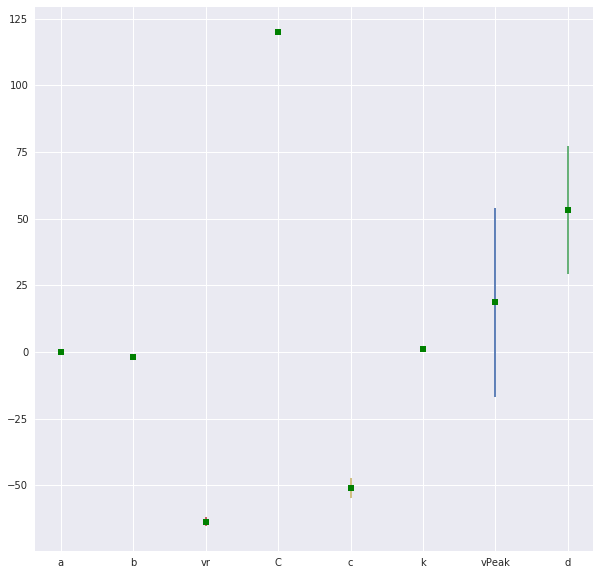

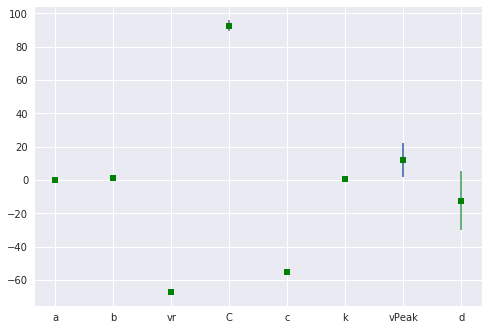

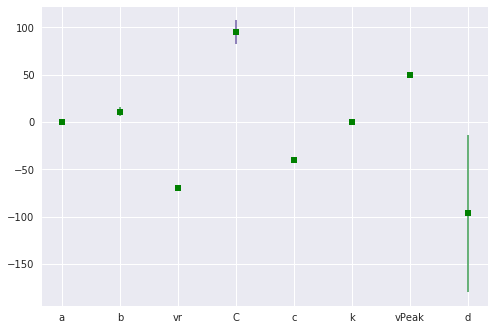

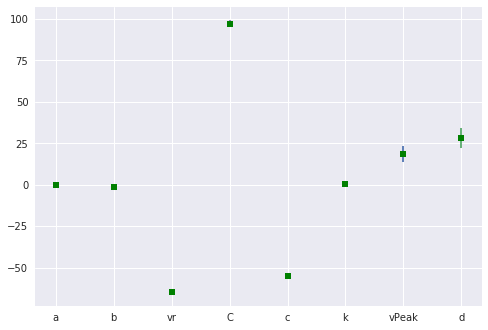

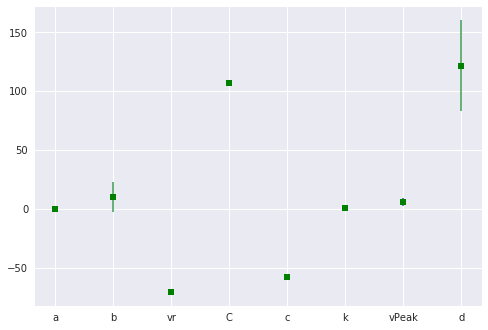

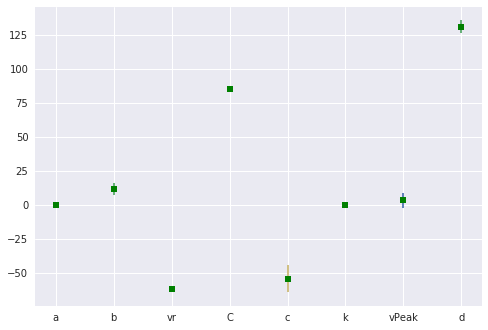

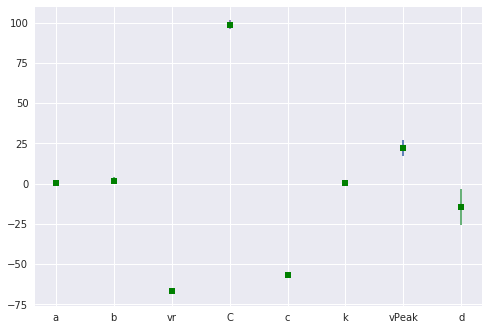

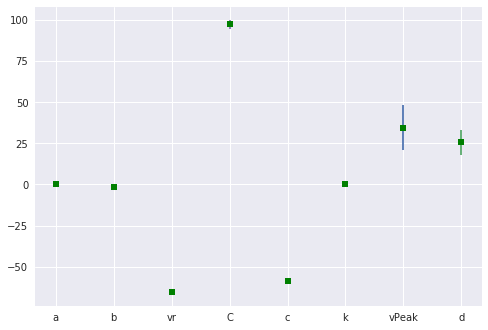

In [55]:
import seaborn as sns
from matplotlib.pyplot import errorbar
import matplotlib.pyplot as plt

fig0,ax0 = plt.subplots(len(test_opt),1,figsize=(10,10))

cnt=0
for key,value in test_opt.items():

    x = 0
    labels = []
    plt.clf()
    for k in value['hof'][0].dtc.attrs.keys():
        
        value = ranges[key][k]

        y = np.mean(value)
        err = max(value)-min(value)
        errorbar(x, y, err, marker='s', mfc='red',
                 mec='green', ms=2, mew=4,label='in '+str(k))
        x+=1
        labels.append(k)
    plt.xticks(np.arange(len(labels)), labels)
    ax0[cnt] = plt
    cnt+=1
    plt.show()



# Visualize the clusters

In [80]:
first_test = all_val[list(all_val.keys())[0]].values()
ft = all_val[list(all_val.keys())[0]]

X = list(first_test)
X_labels = all_val[list(all_val.keys())[0]].keys()

df1 = pd.DataFrame(X)
df1 = df.T
X_labels
df1 = pd.DataFrame(df1,columns=X_labels)

#for i,j in enumerate(first_test):
#    print(i)
    #for key in X_labels:
    #    df1.loc[key].iloc[i] = ft[key][i]

#print(X)

df1 = df1.T 
df1

,a,b,vr,C,c,k,vPeak,d
a,0.018729,-1.996775,-62.895307,119.998451,-49.159430,0.958690,0.954314,41.154992
b,0.016536,-1.997086,-63.513692,119.997747,-49.048533,0.971326,22.718795,52.086958
vr,0.020146,-1.993379,-62.826583,119.998463,-50.611478,0.974180,25.781052,63.856565
C,0.020146,-1.993379,-62.826583,119.998463,-50.611478,0.974180,29.687157,53.384804
c,0.018729,-1.996775,-64.477400,119.998451,-49.159430,0.931575,3.280176,62.348549
k,0.020146,-1.993379,-62.811575,119.998450,-52.906473,0.999911,36.390496,65.316832
vPeak,0.954314,22.718795,25.781052,29.687157,3.280176,36.390496,NaN,NaN
d,41.154992,52.086958,63.856565,53.384804,62.348549,65.316832,NaN,NaN


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


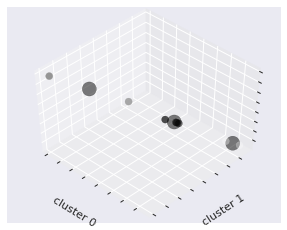

In [81]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import datasets
import seaborn as sns; sns.set()  # for plot styling
X = np.array(X)
est = KMeans(n_clusters=3)

est.fit(X)

y_kmeans = est.predict(X)
centers = est.cluster_centers_

fignum = 1
fig = plt.figure(fignum, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_kmeans, s=50)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5);
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('cluster 0')
ax.set_ylabel('cluster 1')
ax.set_zlabel('cluster 2')
fig.savefig('3dCluster.png')

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.columns
#finalDf = pd.concat([principalDf, df[['target']]], axis = 1)

Index(['principal component 1', 'principal component 2'], dtype='object')

In [92]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df['a'], df['b'], df['C']], axis = 1)
finalDf.columns

/opt/conda/lib/python3.5/site-packages/pandas/core/indexes/range.py:465: RuntimeWarning: unorderable types: int() < str(), sort order is undefined for incomparable objects
  return self._int64index.union(other)


Index(['principal component 1', 'principal component 2', 'a', 'b', 'C'], dtype='object')

In [95]:
finalDf

,principal component 1,principal component 2,a,b,C
0,-25.067166,-4.887200,NaN,NaN,NaN
1,-29.999666,-4.800833,NaN,NaN,NaN
2,-179.944679,-1.496325,NaN,NaN,NaN
3,268.747190,-9.907167,NaN,NaN,NaN
4,-148.223455,-5.491538,NaN,NaN,NaN
5,-22.742152,-4.885931,NaN,NaN,NaN
6,23.879481,26.437402,NaN,NaN,NaN
7,113.350447,5.031593,NaN,NaN,NaN
a,NaN,NaN,0.018729,-1.996775,119.998451
b,NaN,NaN,0.016536,-1.997086,119.997747


ValueError: Cannot index with multidimensional key

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


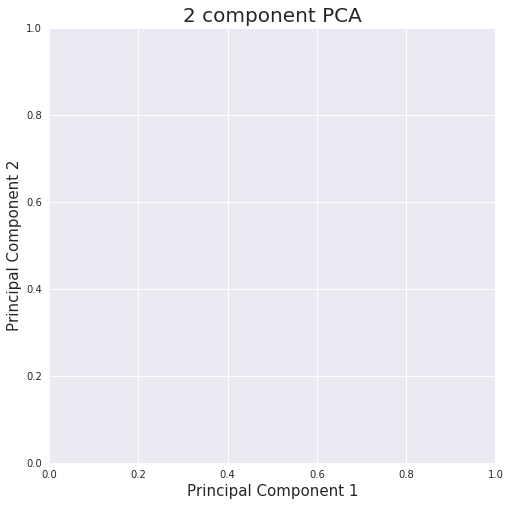

In [94]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = ['a', 'b', 'C']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

In [17]:
with open('data_dump.p','rb') as f:
    test_opt = pickle.load(f)

In [18]:
test_opt

{}

In [19]:
import seaborn as sns
from matplotlib.pyplot import errorbar
import matplotlib.pyplot as plt

fig0,ax0 = plt.subplots(dim,dim,figsize=(10,10))
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

for v in test_opt.values():
    x = 0
    labels = []
    plt.clf()
    for k_,v_ in v['ranges'].items(): 
        value = v_

        y = np.mean(value)
        err = max(value)-min(value)
        errorbar(x, y, err, marker='s', mfc='red',
                 mec='green', ms=2, mew=4,label='in '+str(k_))
        x+=1
        labels.append(k_)
    plt.xticks(np.arange(len(labels)), labels)
    ax0[i] = plt

plt.show()


NameError: name 'dim' is not defined

# the parameter 'd' only seems important
# C does not have to be too precise within a range.

I consider the final gene populations for each of the eight tests. I compute the variance in each of the converged populations, I see that variance is low in many of the gene populations.

When all variables are used to optomize only against one set of parameters, you expect their would be high variance in parameters, that don't matter much with respect to that error criteria (you expect redundancy of solutions).

I compute std on errors over all the tests in order to estimate how amenable the problem is to multiobjective optimization.

In [ ]:
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import quantities as pq
plt.figure(num=None, figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

for k,v in test_opt.items():    
    model = ReducedModel(LEMS_MODEL_PATH, name= str('vanilla'), backend=('RAW'))
    model.attrs = v['out']['pf'][1].dtc.attrs
    print(str(k), v['out']['pf'][1].dtc.get_ss())#fitness)
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =v['out']['pf'][1].rheobase['value']*pq.pA
    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)

    model.inject_square_current(iparams)

    plt.plot(model.get_membrane_potential().times,model.get_membrane_potential(),label=str(k))
    plt.legend()
plt.show()


In [ ]:

DO.seed_pop = npcl['pf'][0:MU]
npcl, DO = om.run_ga(explore_param,10,reduced_tests,free_params=free_params,hc = hc, NSGA = False, MU = MU, seed_pop = DO.seed_pop)


In [ ]:
attrs_here = npcl['hardened'][0][0].attrs
attrs_here.update(hc)
attrs_here
scores = npcl['hof'][0].dtc.scores
print(scores)

In [ ]:
#
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
reduced_tests = [use_test[0], use_test[-1], use_test[len(use_test)-1]]
bigger_tests = use_test[1:-2]
bigger_tests.insert(0,use_test[0])

In [ ]:
#bigger_tests = bigger_tests[-1::]
print(bigger_tests)

In [ ]:
DO.seed_pop = npcl['hof'][0:MU]
reduced_tests = [use_test[0], use_test[-1], use_test[len(use_test)-1]]
npcl, DO = om.run_ga(explore_param,10,bigger_tests,free_params=free_params,hc = hc, NSGA = False, MU = MU)#, seed_pop = DO.seed_pop)


In [ ]:
print(npcl['hardened'][0][0].attrs)
print(npcl['hardened'][0][0].scores)
print(npcl['pf'][0].fitness.values)
print(npcl['hof'][0].dtc.scores)

#for t in use_test:
#    print(t.name)
    
    
pop

# From the scores printed above, it looks like certain error criteria, are in conflict with each other.

Tests, that are amenable to co-optimization appear to be:
* Width test
* Input resistance tets
* Resting Potential Test,
* Capicitance test.
* Time constant

Tests/criteria that seem in compatible with the above include: 
* Rheobase, 
* InjectedCurrentAPThresholdTest
* InjectedCurrentAPAmplitudeTest

Therefore a reduced set of lists is made to check if the bottom three are at least amenable to optimization togethor.

In [ ]:
from sklearn.cluster import KMeans
est = KMeans(n_clusters=2)
est.fit(X)
y_kmeans = est.predict(X)

centers = est.cluster_centers_

fig = plt.figure(fignum,figsize=(4,3))
ax = Axes3D(fig,rect=[0,0,.95,1],elav=48,azim=134)
ax.scatter(X[:,0],X[:,1],X[:,2],c=y_kmeans,s=50),
ax.scatter(centres[:,0],centres[:,1],centres[:,2],c='black',s=200,alpha=0.5)

In [ ]:

print(reduced_tests)
print(bigger_tests)

DO.seed_pop = npcl['pf'][0:MU]
npcl, DO = om.run_ga(explore_param,10,reduced_tests,free_params=free_params,hc = hc, NSGA = True, MU = 12)#, seed_pop = DO.seed_pop)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from neuronunit.optimization.optimization_management import wave_measure
from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
for i in npcl['pf'][0:2]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =i.dtc.rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i.dtc.attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        #print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot


from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
for i in npcl['hardened']:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] = i[0].rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i[0].attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


'''
hc = {}

#free_params = ['c','k']
for k,v in explore_param.items():
    if k not in free_params:
        hc[k] = v
constants = npcl['hardened'][0][0].attrs
hc.update(constants) 
npcl, _ = om.run_ga(explore_param,20,test_frame["Neocortex pyramidal cell layer 5-6"],free_params=free_params,hc = hc, NSGA = True)
'''

In [ ]:

free_params = ['a','b','k']#vt','c','k','d']#,'vt','k','c','C']#,'C'] # this can only be odd numbers.

##
# Use information that is available
##
hc = reduced_cells['RS']

hc['vr'] = -65.2261863636364

hc['vPeak'] = hc['vr'] + 86.364525297619
hc['C'] = 89.7960714285714
hc.pop('a',0)
hc.pop('b',0)
hc.pop('k',0)
hc.pop('c',0)
hc.pop('d',0)
        
use_test = test_frame["Neocortex pyramidal cell layer 5-6"]
#DO.seed_pop = npcl['pf']
#ga_out = DO.run(max_ngen = 15)


In [ ]:
'''
import pandas
    
try:
    ne_raw = pandas.read_csv('article_ephys_metadata_curated.csv', delimiter='\t')
    !ls -ltr *.csv
except:
    !wget https://neuroelectro.org/static/src/article_ephys_metadata_curated.csv
    ne_raw = pandas.read_csv('article_ephys_metadata_curated.csv', delimiter='\t')

blah = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]
#ne_raw['NeuronName']
#ne_raw['cell\ capacitance']
#blah = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]

print([i for i in blah.columns])
#rint(blah['rheobase'])
#print(blah)
#for i in ne_raw.columns:#['NeuronName']:
#    print(i)

#ne_raw['NeuronName'][85]
#blah = ne_raw[ne_raw['TableID'].str.match('85')]
#ne_raw['n'] = 84
#here = ne_raw[ne_raw['Index']==85]
here = ne_raw[ne_raw['TableID']==18]

print(here['rheo_raw'])
#!wget https://neuroelectro.org/apica/1/n/
'''

In [ ]:
ca1 = ne_raw[ne_raw['NeuronName'].str.match('Hippocampus CA1 pyramidal cell')]
ca1['rheo']

In [ ]:

    
test_frame["Dentate gyrus basket cell"][0].observation['std'] = test_frame["Dentate gyrus basket cell"][0].observation['mean']
for t in test_frame["Dentate gyrus basket cell"]:
    print(t.name)

    print(t.observation)
    


'''
Inibitory Neuron
This can't pass the Rheobase test
'''    

In [ ]:

from neuronunit.optimization import optimization_management as om
import pickle

free_params = ['a','vr','b','vt','vPeak','c','k']
for k,v in explore_param.items():
    if k not in free_params:
        hc[k] = v
use_test = test_frame["Dentate gyrus basket cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 4)


In [ ]:

    
#test_frame["Dentate gyrus basket cell"][0].observation['std'] = test_frame["Dentate gyrus basket cell"][0].observation['mean']
for t in test_frame["Hippocampus CA1 pyramidal cell"]:
    print(t.name)

    print(t.observation)

In [ ]:
use_test = test_frame["Hippocampus CA1 pyramidal cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 10)


In [ ]:
import pickle
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuronunit.models.reduced import ReducedModel
from neuronunit.optimization.model_parameters import model_params, path_params
LEMS_MODEL_PATH = path_params['model_path']
import neuronunit.optimization as opt
import quantities as pq
fig = plt.figure()

plt.clf()

from neuronunit.optimization.data_transport_container import DataTC
for i in bcell['hardened'][0:6]:
    iparams = {}
    iparams['injected_square_current'] = {}
    iparams['injected_square_current']['amplitude'] =i[0].rheobase
    model = None
    model = ReducedModel(LEMS_MODEL_PATH,name = str('vanilla'),backend = ('RAW'))
    model.set_attrs(i[0].attrs)

    #['amplitude']  = dtc.vtest[k]['injected_square_current']['amplitude']
    DELAY = 100.0*pq.ms
    DURATION = 1000.0*pq.ms
    iparams['injected_square_current']['delay'] = DELAY
    iparams['injected_square_current']['duration'] = int(DURATION)
    model.inject_square_current(iparams)
    n_spikes = len(model.get_spike_train())
    if n_spikes:
        print(n_spikes)
        print(i[0].scores['RheobaseTestP']*pq.pA)
        plt.plot(model.get_membrane_potential().times,model.get_membrane_potential())#,label='ground truth')
        plt.legend()

#gca().set_axis_off()
#subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#            hspace = 0, wspace = 0)
#margins(0,0)
#gca().xaxis.set_major_locator(NullLocator())
#gca().yaxis.set_major_locator(NullLocator())

plt.subplots_adjust(left=0.0, right=1.0, top=0.9, bottom=0.1)
fig.tight_layout()
plt.show()

fig.savefig("single_trace.png", bbox_inches = 'tight',
    pad_inches = 0)


In [ ]:
use_test = test_frame["Hippocampus CA1 pyramidal cell"]
bcell, _ = om.run_ga(explore_param,20,use_test,free_params=free_params,hc = hc, NSGA = True, MU = 10)


# This cell is in markdown, but it won't be later.
Later optimize a whole heap of cells in a loop.

try:
    import pickle
    with open('data_dump.p','rb') as f:
        test_opt = pickle.load(f)
except:
    MU = 12
    NGEN = 25
    cnt = 1
    for t in use_test:        
        if cnt==len(use_test):
            MU = 12
            NGEN = 20

            npcl, DO = om.run_ga(explore_param,NGEN,[t],free_params=free_params, NSGA = True, MU = MU)
        else:

            npcl, DO = om.run_ga(explore_param,NGEN,[t],free_params=free_params, NSGA = True, MU = MU)

        test_opt[str(t)] =  {'out':npcl}

        ranges = {}
        stds = npcl['pop'][0].dtc.attrs
        for k in npcl['pop'][0].dtc.attrs.keys():    
            stds[k] = []
            ranges[k] = []


        for i in npcl['pop'][::5]:
            for k,v in i.dtc.attrs.items():
                stds[k].append(v)
                ranges[k].append(v)

        for k in npcl['pop'][0].dtc.attrs.keys():
            ranges[k] = (np.min(ranges[k][1::]),np.max(ranges[k][1::]))

            stds[k] = np.std(stds[k][1::])
        test_opt[str(t)]['stds'] = stds 
        test_opt[str(t)]['ranges'] = ranges 

        cnt+=1
    
    with open('data_dump.p','wb') as f:
        pickle.dump(test_opt,f)
       